In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
updateSavedModel = False

# Read in Data

In [3]:
train_dset = tf.data.experimental.load('../data/dsets/train_dset-16',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets/val_dset-16',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets/test_dset-16',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))

In [4]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # for model evaluation
y_test = [np.where(r==1)[0][0] for r in y_test] # convert from one-hot to integer

# Model

In [19]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

num_hidden_units = 128
num_outputs = 7

model = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 171)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units)),
    tf.keras.layers.Dense(num_outputs,activation='softmax')
])

input_layer = tf.keras.Input(shape=(300, 171)) 
# model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 300, 256)          307200    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1799      
Total params: 703,239
Trainable params: 703,239
Non-trainable params: 0
_________________________________________________________________


In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50,restore_best_weights=True)
EPOCHS = 30

history = model.fit(train_dset,epochs=EPOCHS,validation_data = val_dset,callbacks=[es])
# TODO definitely needs more epochs (see loss curve below)

Epoch 1/30
100/100 [==============================] - 27s 274ms/step - loss: 2.0224 - accuracy: 0.1456 - val_loss: 1.9463 - val_accuracy: 0.1050
Epoch 2/30
100/100 [==============================] - 25s 246ms/step - loss: 1.9446 - accuracy: 0.1488 - val_loss: 1.9408 - val_accuracy: 0.1050
Epoch 3/30
100/100 [==============================] - 25s 246ms/step - loss: 1.9441 - accuracy: 0.1475 - val_loss: 1.9392 - val_accuracy: 0.1050
Epoch 4/30
100/100 [==============================] - 25s 247ms/step - loss: 1.9438 - accuracy: 0.1462 - val_loss: 1.9395 - val_accuracy: 0.1050
Epoch 5/30
100/100 [==============================] - 25s 246ms/step - loss: 1.9439 - accuracy: 0.1450 - val_loss: 1.9398 - val_accuracy: 0.1050
Epoch 6/30
100/100 [==============================] - 25s 247ms/step - loss: 1.9440 - accuracy: 0.1469 - val_loss: 1.9389 - val_accuracy: 0.1050
Epoch 7/30
100/100 [==============================] - 34s 345ms/step - loss: 1.9439 - accuracy: 0.1437 - val_loss: 1.9392 - val_ac

KeyboardInterrupt: 

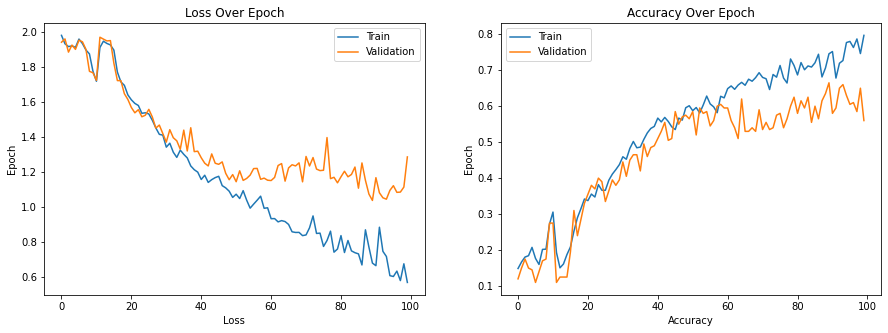

In [7]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

# TODO definitely something sketchy with this loss, could be a learning rate thing?

In [8]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 1s 88ms/step - loss: 1.1680 - accuracy: 0.6250
Test accuracy: 0.625


In [9]:
# save model
if updateSavedModel:
    model.save("trained-models/model_lstm")

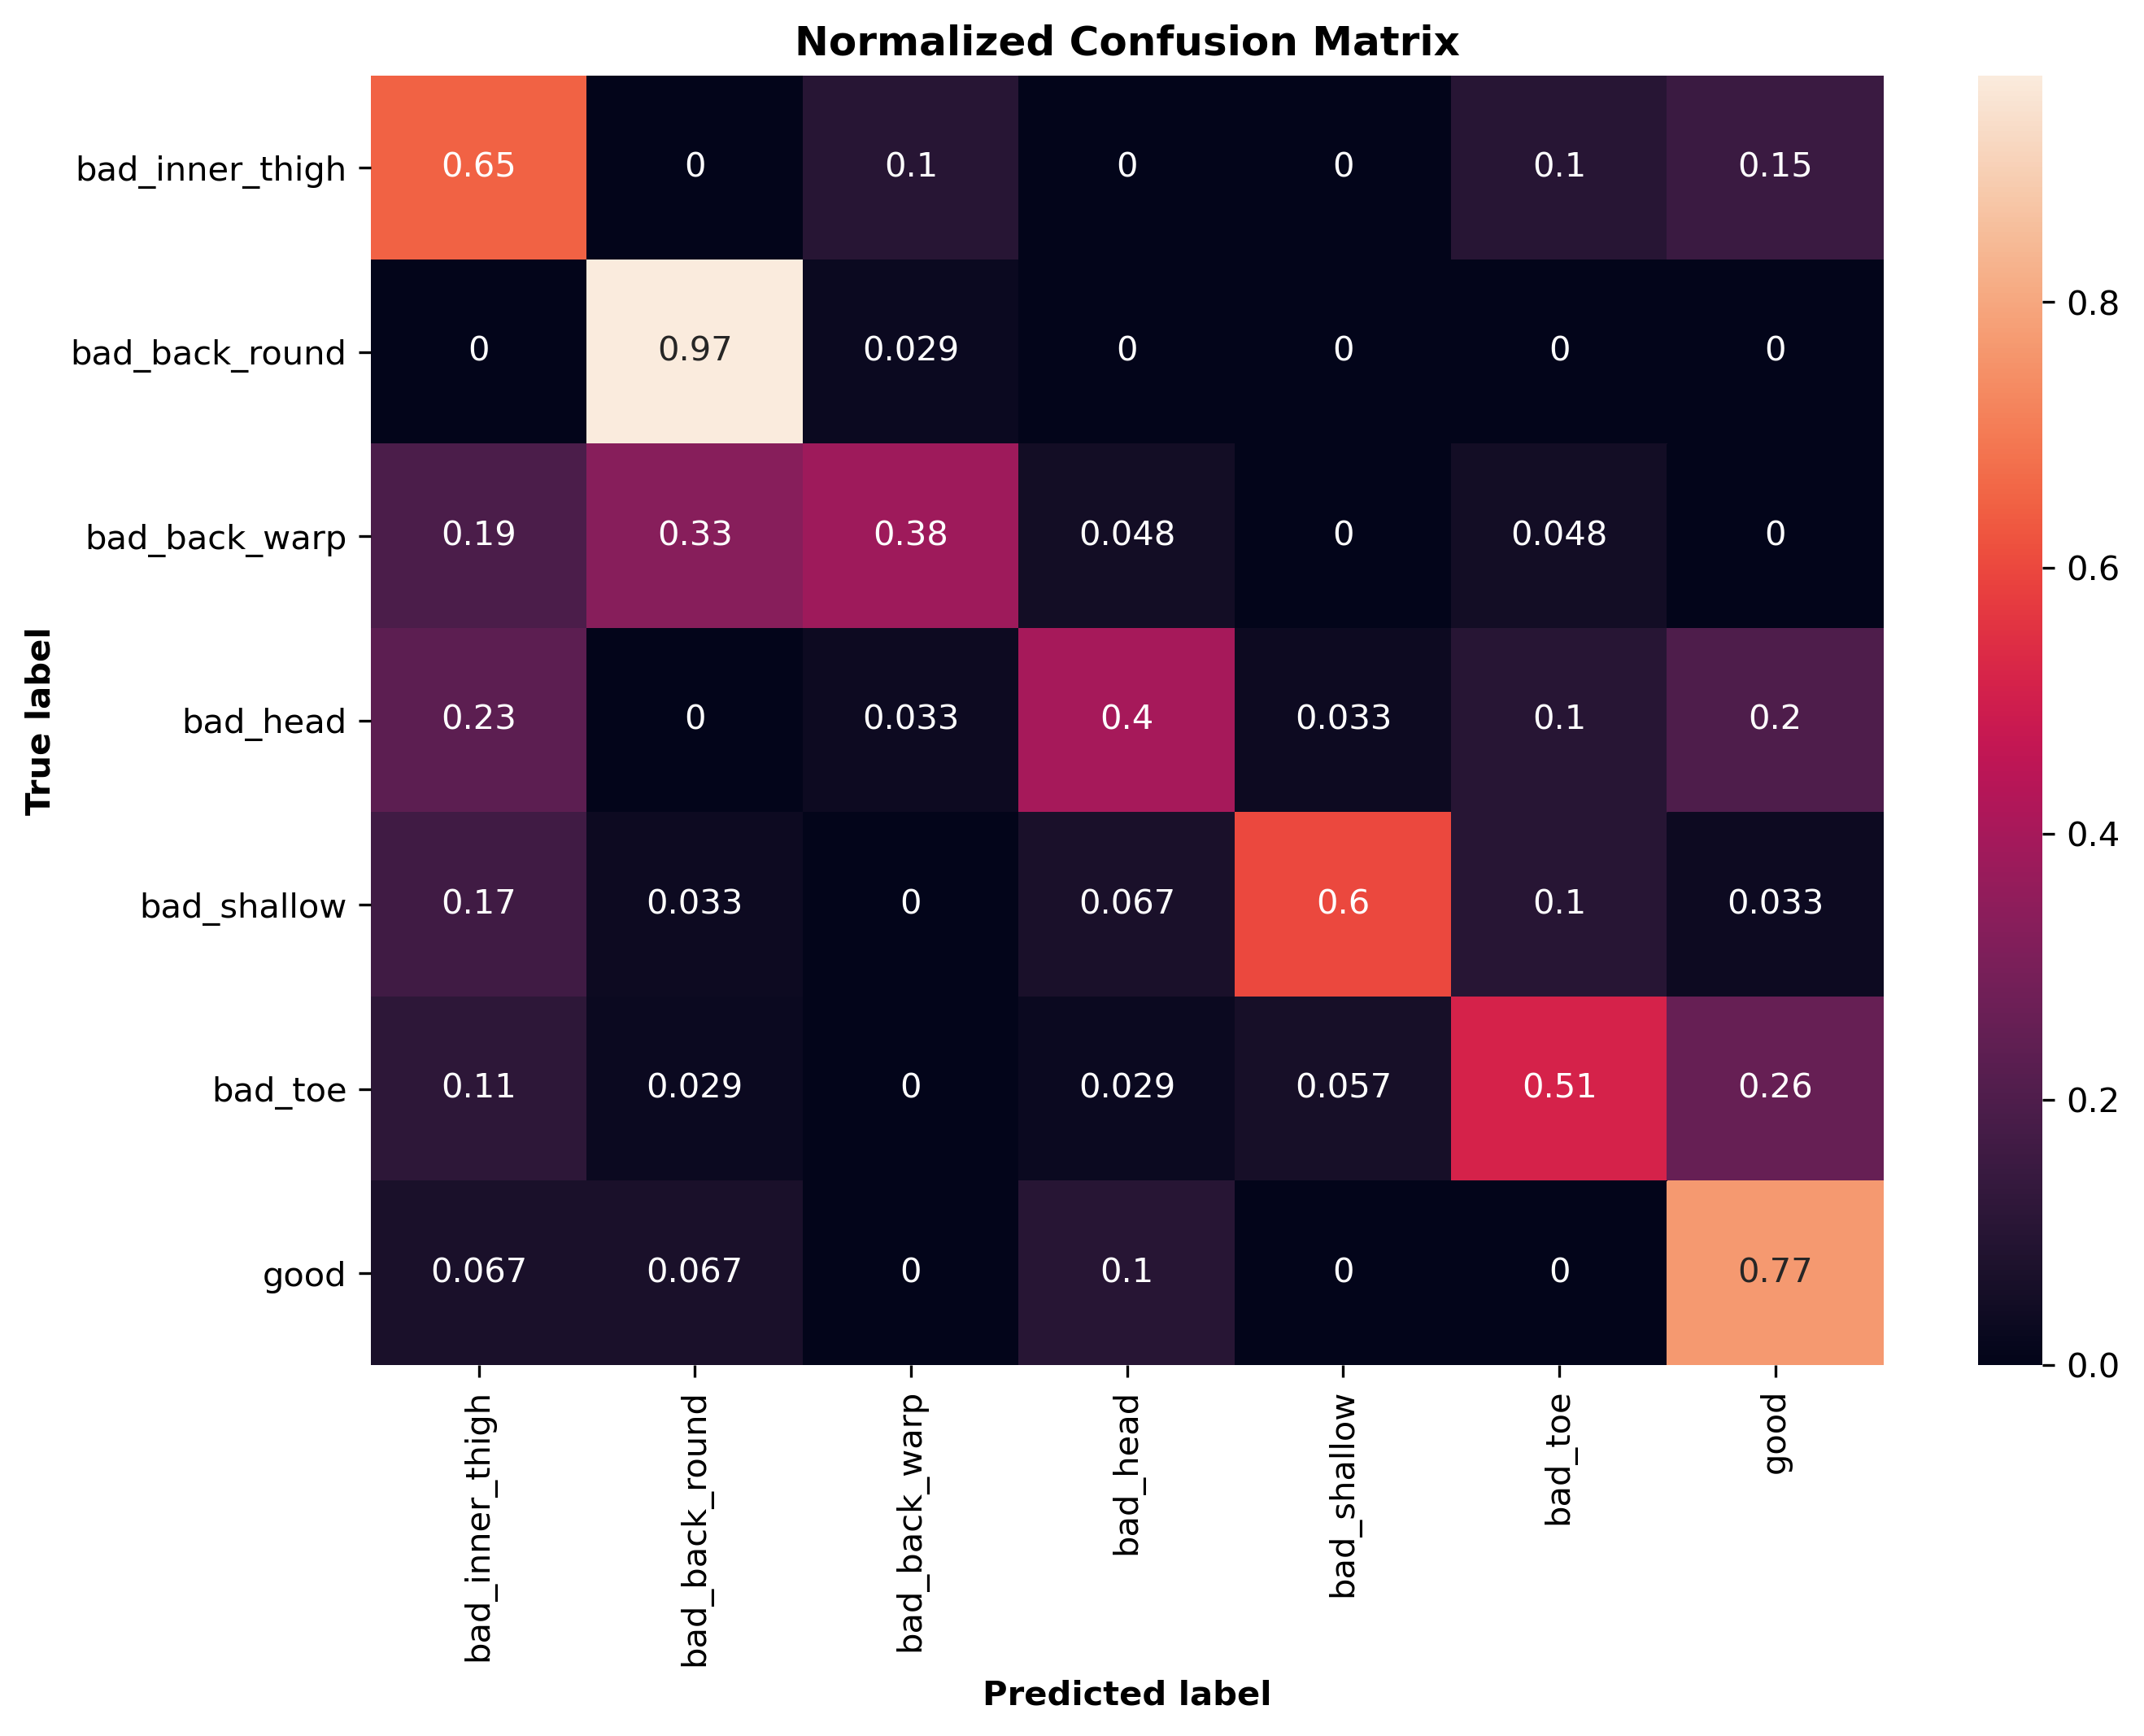


Accuracy: 0.62

Micro Precision: 0.62
Micro Recall: 0.62
Micro F1-score: 0.62

Macro Precision: 0.64
Macro Recall: 0.61
Macro F1-score: 0.60

Weighted Precision: 0.66
Weighted Recall: 0.62
Weighted F1-score: 0.62

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.37      0.65      0.47        20
 bad_back_round       0.75      0.97      0.85        34
  bad_back_warp       0.67      0.38      0.48        21
       bad_head       0.63      0.40      0.49        30
    bad_shallow       0.86      0.60      0.71        30
        bad_toe       0.67      0.51      0.58        35
           good       0.55      0.77      0.64        30

       accuracy                           0.62       200
      macro avg       0.64      0.61      0.60       200
   weighted avg       0.66      0.62      0.62       200

Cohen Kappa Statistic



0.560722757489677

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)